# Empirische Analyse    -   Allgemeines

## Importe

In [23]:
#### Jupyter Einstellungen

%load_ext autoreload
%autoreload 2

#### Python Importe

from zoneinfo import ZoneInfo
import locale
import datetime as dt

locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')
tz = ZoneInfo('Europe/Berlin')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import math
import numpy as np
import pandas as pd
from pandas import IndexSlice as IDX

# CITE !!
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

import itertools
import os 

import src.preprocessing as pp
from src.preprocessing import getDB, getAdaptiveComfort, getData
import src.toolbox as tb
import src.style as style
from src.style import size, TexMapper

#### Datenbank Import

try:
    from src.preprocessing import BUID, ROOMS, APPS, DB, AMB
except ImportError:
    getDB()
    from src.preprocessing import BUID, ROOMS, APPS, DB, AMB
DB.head(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


bui                          LB                                           \
app                           N                                            
room                          B                                            
value                     HK_IO  Rh Rh_amb T_amb T_amb_g24 Tair Thk Tset   
Datetime                                                                   
2021-02-08 11:00:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:01:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   

bui                                      ...  MW                              \
app                                      ...   S                               
room                                  K  ...  WZ                               
value                     g_abs Fenster  ...  Rh Rh_amb T_amb T_amb_g24 Tair   
Datetime                                 ...                                   
2021-02-08 11:00:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:01:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   

bui                                               
app                                               
room                                              
value                     Thk Top Tset Tsk g_abs  
Datetime                                          
2021-02-08 11:00:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:01:00+01:00 NaN NaN  NaN NaN   NaN  

[2 rows x 408 columns]

# ANALYSE

In [24]:
cols = [lvl for lvl in DB.columns for x in ['CO2', 'Fenster','Fensteröffnung', 'Tair','Rh','Rh_amb', 'T_amb', 'T_amb_g24', 'HK_IO', 'Top', 'Tset', 'g_abs'] if x in lvl]
_DB = DB[cols].loc[:,IDX[:,['N', 'S'],:,:]].resample('H').mean().stack(level=[0,1,2]).dropna(how='all').reset_index().dropna(how='all', axis=1)
_DB['Hour'] = _DB['Datetime'].dt.hour
_DB['Month'] = _DB['Datetime'].dt.month
_DB = _DB.merge(getAdaptiveComfort(flat=True).stack([0,1]).reset_index(), left_on=['Datetime', 'bui', 'app'], right_on=['Datetime', 'bui', 'app'], how='left')
_DBopen = _DB[_DB['Fensteröffnung'] > 0].copy()
_DBclose = _DB[_DB['Fensteröffnung'] < 0].copy()
_DBclose['Fensteröffnung'] = _DBclose['Fensteröffnung'].abs()

<AxesSubplot:xlabel='gleitender Mittelwert der Außenlufttemperatur [\\si{\\celsius}]', ylabel='rel. Häufigkeit'>

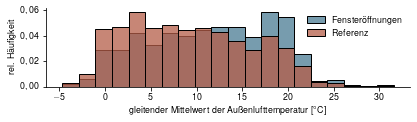

In [25]:
obs = np.repeat(_DBopen['T_amb_g24'], _DBopen['Fensteröffnung']).dropna().reset_index(drop=True)
obs2 = np.repeat(_DBclose['T_amb_g24'], _DBclose['Fensteröffnung']).dropna().reset_index(drop=True)
exp = _DB['T_amb_g24'].dropna().reset_index(drop=True)

tb.stats.histanalyse(obs, exp, kind='Hist', xlabel=r'gleitender Mittelwert der Außenlufttemperatur [\si{\celsius}]')

<AxesSubplot:xlabel='Außenlufttemperatur [\\si{\\celsius}]', ylabel='rel. Häufigkeit'>

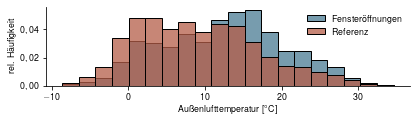

In [26]:
obs = np.repeat(_DBopen['T_amb'], _DBopen['Fensteröffnung']).dropna().reset_index(drop=True)
exp = _DB['T_amb'].dropna().reset_index(drop=True)

tb.stats.histanalyse(obs, exp, kind='Hist', xlabel=r'Außenlufttemperatur [\si{\celsius}]')

<AxesSubplot:xlabel='Uhrzeit', ylabel='rel. Häufigkeit'>

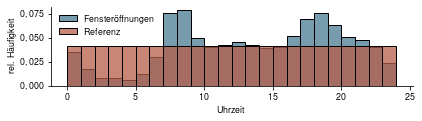

In [27]:
obs = np.repeat(_DBopen['Hour'], _DBopen['Fensteröffnung']).dropna().reset_index(drop=True)
exp = _DB['Hour'].dropna().reset_index(drop=True)

tb.stats.histanalyse(obs, exp, kind='Hist', bins=np.arange(0,25,1), xlabel=r'Uhrzeit')

<AxesSubplot:xlabel='$CO_2$ Konzentration [ppm]', ylabel='rel. Häufigkeit'>

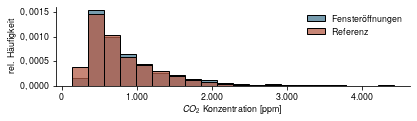

In [28]:
obs = np.repeat(_DBopen['CO2'], _DBopen['Fensteröffnung']).dropna().reset_index(drop=True)
exp = _DB['CO2'].dropna().reset_index(drop=True)

tb.stats.histanalyse(obs, exp, kind='Hist', xlabel=r'$CO_2$ Konzentration [ppm]')

<AxesSubplot:xlabel='beobachtete Quantile [-]', ylabel='erwartete Quantile [-]'>

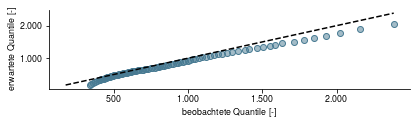

In [29]:
tb.stats.qqplot(obs.round(), exp.round())

<AxesSubplot:xlabel='beobachtete Quantile [-]', ylabel='erwartete Quantile [-]'>

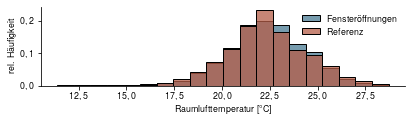

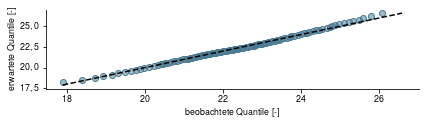

In [30]:
obs = np.repeat(_DBopen['Tair'], _DBopen[ 'Fensteröffnung']).dropna().reset_index(drop=True)
exp = _DB['Tair'].dropna().reset_index(drop=True)

tb.stats.histanalyse(obs, exp, kind='Hist', xlabel=r'Raumlufttemperatur [\si{\celsius}]')
tb.stats.qqplot(obs, exp, test=None)

<AxesSubplot:xlabel='beobachtete Quantile [-]', ylabel='erwartete Quantile [-]'>

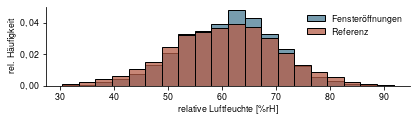

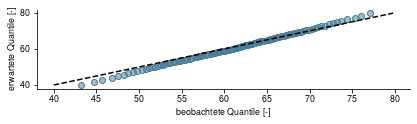

In [31]:
obs = np.repeat(_DBopen['Rh'], _DBopen[ 'Fensteröffnung']).dropna().reset_index(drop=True)
exp = _DB['Rh'].dropna().reset_index(drop=True)

tb.stats.histanalyse(obs, exp, kind='Hist', xlabel='relative Luftfeuchte [\si{\percent rH}]')
tb.stats.qqplot(obs, exp)

<AxesSubplot:xlabel='beobachtete Quantile [-]', ylabel='erwartete Quantile [-]'>

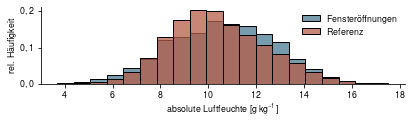

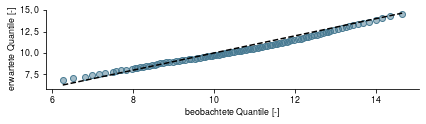

In [32]:
obs = np.repeat(_DBopen['g_abs'], _DBopen[ 'Fensteröffnung']).dropna().reset_index(drop=True)
exp = _DB['g_abs'].dropna().reset_index(drop=True)

tb.stats.histanalyse(obs, exp, kind='Hist', xlabel='absolute Luftfeuchte [\si{\gram\per\kilogram}]')
tb.stats.qqplot(obs, exp)

,Fenster,T_amb
Datetime,,
2021-03-08 11:18:00+01:00,0.333333,5.0
2021-03-08 11:19:00+01:00,0.333333,5.1
2021-03-08 11:20:00+01:00,0.333333,5.1
2021-03-08 11:21:00+01:00,0.333333,5.1
2021-03-08 11:22:00+01:00,0.333333,5.1


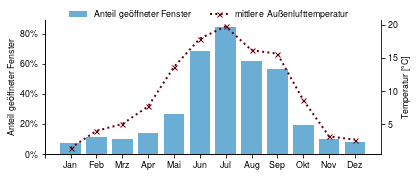

In [33]:
fig, ax = plt.subplots(**size(.4))
ax1 = ax.twinx()
df = pd.DataFrame(DB.loc[:, IDX[:,:,:,'Fenster']].groupby(level=[0,1], axis=1).sum(min_count=1).mean(axis=1), columns=['Fenster'])
_df = df.groupby(df.index.month).mean()
ax.bar(_df.index, _df.iloc[:,0], color=mpl.cm.Blues(0.5), label='Anteil geöffneter Fenster')
ax1.plot(AMB.groupby(AMB.index.month).mean()['T_amb'], color=mpl.cm.Reds(255), marker='x', ms='5', linestyle='dotted', linewidth=2, label='mittlere Außenlufttemperatur')
ax1.spines['right'].set_visible(True)
fig.legend(ncol=2, bbox_to_anchor=(0.5,.9), loc='lower center', frameon=False)
ax.set_ylabel('Anteil geöffneter Fenster')
ax1.set_ylabel('Temperatur [\si{\celsius}]')
ax.set_xticks(np.arange(0,13,1), ['', *[pd.to_datetime(x, format='%m').strftime('%b') for x in range(1,13)]])
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1,0))
fig.tight_layout()

df['T_amb'] = AMB.T_amb
df.dropna(inplace=True)
df.head()

## Korrelationsanalyse

### Geclustert nach Wohnungen

In [34]:
#data = DB.loc[:,IDX[:,['N', 'S'],:,:]].filter(regex='|'.join(['Rh','Rh_amb', 'Tair', 'CO2', 'Anwesenheit', 'g_abs', 'T_amb', 'T_amb_g24', 'Top'])).groupby(level=[0,1,3], axis=1).mean().resample('15min').mean().stack([0,1])
data =  pp.getData(app=['N', 'S'], value=['Rh','Rh_amb', 'Tair', 'CO2', 'Anwesenheit', 'Fenster', 'g_abs', 'T_amb', 'T_amb_g24', 'Top']).groupby(level=[0,1,3], axis=1).mean().resample('15min').mean().stack([0,1])
#data['Fenster'] = (data['Fenster'] > 0).astype(int)
df = DB.filter(like='Fensteröffnung').stack([0,1,2])
mask = df['Fensteröffnung'] > 0
data = data.merge(df['Fensteröffnung'].mask(~mask).groupby(level=[0,1,2]).sum().abs().unstack([1,2]).resample('15min').sum().stack([0,1]).rename('Öffnung'), right_index=True, left_index=True)
data = data.merge(df['Fensteröffnung'].mask(mask).groupby(level=[0,1,2]).sum().abs().unstack([1,2]).resample('15min').sum().stack([0,1]).rename('Schließung'), right_index=True, left_index=True)
data.reset_index(inplace=True)
data = data.assign(deltaT = lambda x: x.T_amb - x.Tair)
steps = 6
DayRange = [f'{x1}h bis {x2}h' for x1, x2 in zip(np.arange(0,24+steps,steps), np.arange(steps, 24+steps, steps))]
data = data.merge(pd.get_dummies(pd.cut(data.Datetime.dt.hour, bins=np.arange(0,24+steps,steps),labels=DayRange, right=False)), right_index=True, left_index=True)
#data = data.merge(pd.get_dummies(data.Datetime.dt.month_name()), right_index=True, left_index=True)
data = data.merge(pd.get_dummies(tb.utils.getSeason(data.Datetime.dt.month)), right_index=True, left_index=True)
data = data.set_index(['Datetime', 'bui', 'app']).sort_index().round(1)
data = data.where(data.Anwesenheit > 0).dropna(how='all')
data.drop(['Anwesenheit'], axis=1, inplace=True)
data.head()

,,,CO2,Fenster,Rh,Rh_amb,T_amb,T_amb_g24,Tair,Top,g_abs,Öffnung,Schließung,deltaT,0h bis 6h,6h bis 12h,12h bis 18h,18h bis 24h,Sommer,Winter,Übergang
Datetime,bui,app,,,,,,,,,,,,,,,,,,,
2021-03-06 08:30:00+01:00,MW,S,1944.3,0.0,64.6,NaN,NaN,NaN,20.4,NaN,9.8,1.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2021-03-06 08:45:00+01:00,MW,S,523.7,0.3,59.8,NaN,NaN,NaN,19.5,NaN,8.6,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2021-03-06 09:00:00+01:00,MW,S,408.4,0.3,58.7,NaN,NaN,NaN,19.1,NaN,8.4,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2021-03-06 09:15:00+01:00,MW,S,416.6,0.3,58.3,NaN,NaN,NaN,19.1,NaN,8.3,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2021-03-06 09:30:00+01:00,MW,S,418.3,0.3,57.9,NaN,NaN,NaN,18.9,NaN,8.3,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0


[Text(0.44548956063199086, 0.5, ''), Text(0.5, 192.9016200063065, '')]

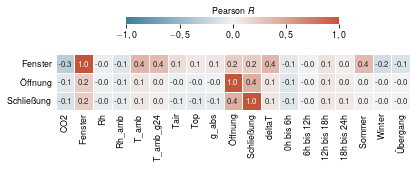

In [35]:
fig, ax = plt.subplots(**style.size(aspect=1))
tb.stats.CorreleationMatrix(data, ax=ax, annot_kws={"size":8}, annot=True, highlights=['Fenster', 'Öffnung', 'Schließung'])
ax.set(ylabel=None, xlabel=None)

<AxesSubplot:>

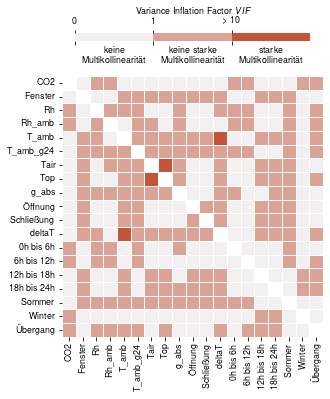

In [36]:
fig, ax = plt.subplots(**style.size(aspect=1))
tb.stats.VIFMatrix(data, ax=ax, triangular=False, annot=False)

### Geclustert nach Räumen

In [37]:
data =  pp.getData(app=['N', 'S'], value=['Rh','Rh_amb', 'Tair', 'CO2', 'Anwesenheit', 'Fenster', 'g_abs', 'T_amb', 'T_amb_g24', 'Top']).resample('15min').mean().stack([0,1,2]).reset_index()
steps = 6
DayRange = [f'{x1} to {x2}' for x1, x2 in zip(np.arange(0,24+steps,steps), np.arange(steps, 24+steps, steps))]
data = data.merge(pd.get_dummies(pd.cut(data.Datetime.dt.hour, bins=np.arange(0,24+steps,steps),labels=DayRange, right=False)), right_index=True, left_index=True)
#data = data.merge(pd.get_dummies(data.Datetime.dt.month_name()), right_index=True, left_index=True)
data = data.merge(pd.get_dummies(tb.utils.getSeason(data.Datetime.dt.month)), right_index=True, left_index=True)
data = data.merge(data.set_index(['Datetime', 'bui', 'app','room'])['CO2'].unstack('room').fillna(axis=1, method='ffill').fillna(axis=1, method='bfill').stack('room').rename('CO2_app'), left_on=['Datetime', 'bui', 'app', 'room'], right_index=True)
data = data.merge(data.set_index(['Datetime', 'bui', 'app','room'])['Anwesenheit'].unstack('room').fillna(axis=1, method='ffill').fillna(axis=1, method='bfill').stack('room').rename('Occ_app'), left_on=['Datetime', 'bui', 'app', 'room'], right_index=True)
data['Fenster'] = (data['Fenster'] > 0).astype(int)
df = DB.filter(like='Fensteröffnung').stack([0,1,2])
mask = df['Fensteröffnung'] > 0
data = data.merge(df['Fensteröffnung'].mask(~mask).fillna(0).abs().unstack([1,2,3]).resample('15min').sum().stack([0,1,2]).rename('Öffnung'), left_on=['Datetime', 'bui', 'app', 'room'], right_index=True)
data = data.merge(df['Fensteröffnung'].mask(mask).fillna(0).abs().unstack([1,2,3]).resample('15min').sum().stack([0,1,2]).rename('Schließung'), left_on=['Datetime', 'bui', 'app', 'room'], right_index=True)
data.drop(['Anwesenheit','CO2'], axis=1, inplace=True)
data = data.set_index(['Datetime', 'bui', 'app', 'room']).sort_index().round(1)
data = data.where(data.Occ_app>0).dropna(how='all')
data.drop(['Occ_app'], axis=1, inplace=True)
data

Fenster    Rh  Rh_amb  T_amb  \
Datetime                  bui app room                                 
2021-03-06 08:30:00+01:00 MW  S   K         0.0  67.9     NaN    NaN   
                                  SZ        1.0  67.3     NaN    NaN   
                                  WZ        0.0  68.4     NaN    NaN   
2021-03-06 08:45:00+01:00 MW  S   K         0.0  67.9     NaN    NaN   
                                  SZ        1.0  48.5     NaN    NaN   
...                                         ...   ...     ...    ...   
2022-06-01 23:45:00+02:00 LB  S   SZ        0.0  61.8    86.1   13.8   
                                  WZ        1.0  68.9    86.1   13.8   
                          MW  N   K         0.0  73.9    86.1   13.8   
                                  SZ        1.0  71.5    86.1   13.8   
                                  WZ        0.0  76.1    86.1   13.8   

                                        T_amb_g24  Tair   Top  g_abs  0 to 6  \
Datetime                  bui app room                                         
2021-03-06 08:30:00+01:00 MW  S   K           NaN  18.6   NaN    9.2     0.0   
                                  SZ          NaN  20.6   NaN   10.4     0.0   
                                  WZ          NaN  19.2   NaN    9.6     0.0   
2021-03-06 08:45:00+01:00 MW  S   K           NaN  18.6   NaN    9.2     0.0   
                                  SZ          NaN  16.8   NaN    5.9     0.0   
...                                           ...   ...   ...    ...     ...   
2022-06-01 23:45:00+02:00 LB  S   SZ         16.2  22.8  22.0   10.9     0.0   
                                  WZ         16.2  22.4  21.8   11.8     0.0   
                          MW  N   K          16.2  22.4   NaN   12.7     0.0   
                                  SZ         16.2  21.8  21.3   11.9     0.0   
                                  WZ         16.2  23.0  22.2   13.6     0.0   

                                        6 to 12  12 to 18  18 to 24  Sommer  \
Datetime                  bui app room                                        
2021-03-06 08:30:00+01:00 MW  S   K         1.0       0.0       0.0     0.0   
                                  SZ        1.0       0.0       0.0     0.0   
                                  WZ        1.0       0.0       0.0     0.0   
2021-03-06 08:45:00+01:00 MW  S   K         1.0       0.0       0.0     0.0   
                                  SZ        1.0       0.0       0.0     0.0   
...                                         ...       ...       ...     ...   
2022-06-01 23:45:00+02:00 LB  S   SZ        0.0       0.0       1.0     1.0   
                                  WZ        0.0       0.0       1.0     1.0   
                          MW  N   K         0.0       0.0       1.0     1.0   
                                  SZ        0.0       0.0       1.0     1.0   
                                  WZ        0.0       0.0       1.0     1.0   

                                        Winter  Übergang  CO2_app  Öffnung  \
Datetime                  bui app room                                       
2021-03-06 08:30:00+01:00 MW  S   K        0.0       1.0   1944.3      0.0   
                                  SZ       0.0       1.0   1944.3      1.0   
                                  WZ       0.0       1.0   1944.3      0.0   
2021-03-06 08:45:00+01:00 MW  S   K        0.0       1.0    523.7      0.0   
                                  SZ       0.0       1.0    523.7      0.0   
...                                        ...       ...      ...      ...   
2022-06-01 23:45:00+02:00 LB  S   SZ       0.0       0.0    890.3      0.0   
                                  WZ       0.0       0.0    890.3      0.0   
                          MW  N   K        0.0       0.0    406.4      0.0   
                                  SZ       0.0       0.0    406.4      0.0   
                                  WZ       0.0       0.0    406.4      0.0   

                   

Fenster       0.3
Rh           -0.0
Rh_amb       -0.0
T_amb         0.1
T_amb_g24     0.0
Tair         -0.0
Top          -0.0
g_abs        -0.0
0 to 6       -0.1
6 to 12      -0.0
12 to 18      0.1
18 to 24      0.0
Sommer        0.0
Winter       -0.0
Übergang     -0.0
CO2_app      -0.1
Schließung    0.5
Name: Öffnung, dtype: float64

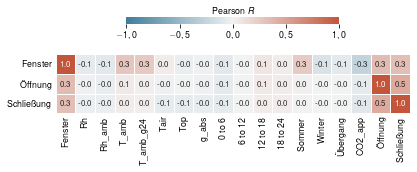

In [38]:
fig, ax = plt.subplots(**style.size(aspect=1))
tb.stats.CorreleationMatrix(data, ax=ax, annot_kws={"size":8}, annot=True, highlights=['Fenster', 'Öffnung', 'Schließung'])
ax.set(ylabel=None, xlabel=None)
data.corr()['Öffnung'].drop('Öffnung').round(1)

<AxesSubplot:>

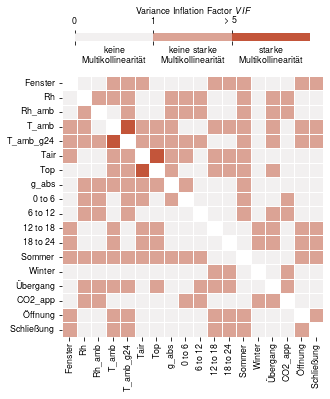

In [39]:
fig, ax = plt.subplots(**style.size(aspect=1))
tb.stats.VIFMatrix(data, ax=ax, triangular=False, annot=False, tresh=5)

Fenster       0.980392
Schließung    0.960784
T_amb         0.833333
12 to 18      0.833333
T_amb_g24     0.705882
18 to 24      0.627451
Sommer        0.617647
Übergang      0.558824
6 to 12       0.539216
g_abs         0.450980
Rh            0.450980
Winter        0.392157
Tair          0.372549
Top           0.254902
Rh_amb        0.176471
CO2_app       0.137255
0 to 6        0.107843
dtype: float64

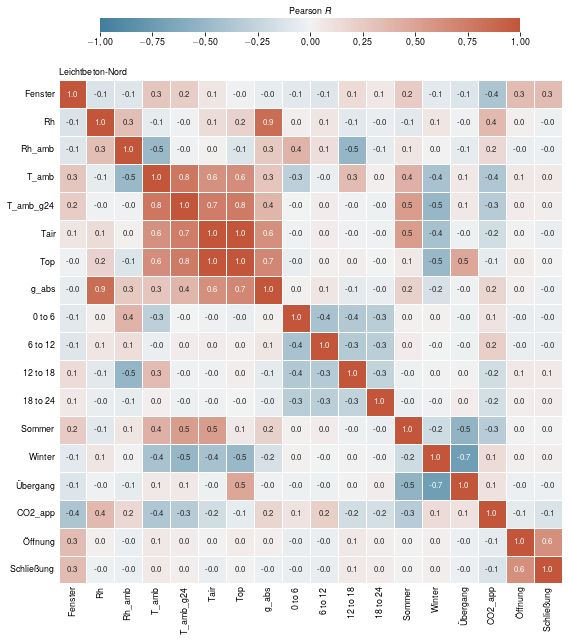

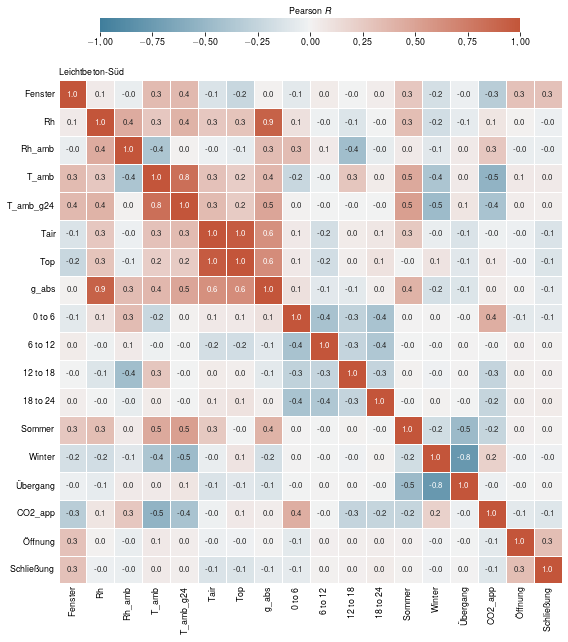

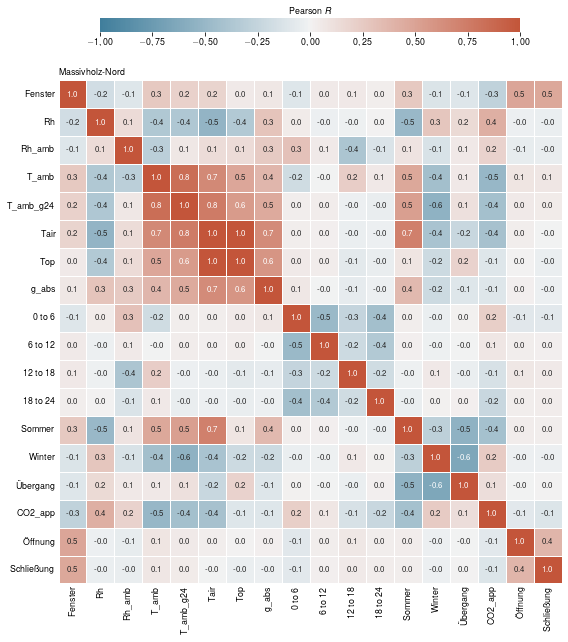

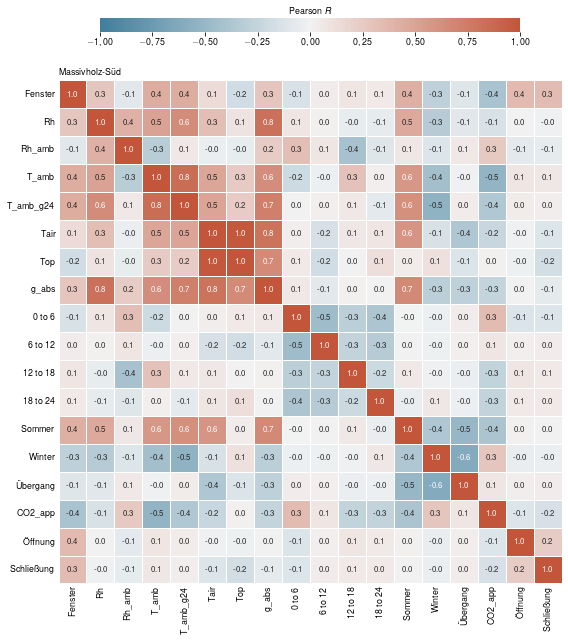

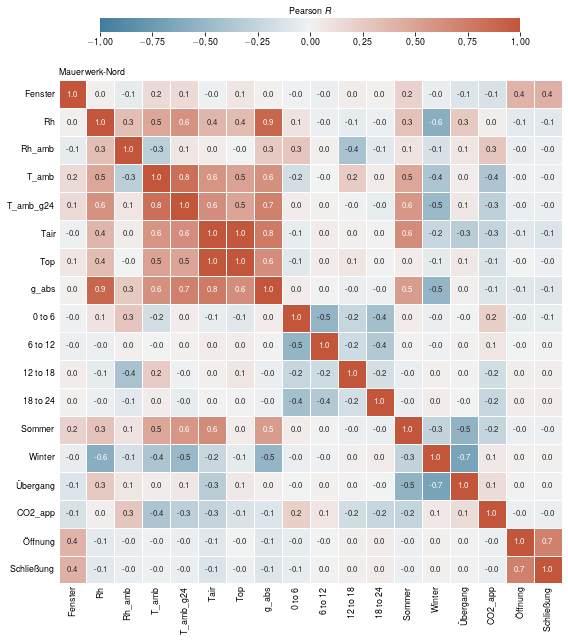

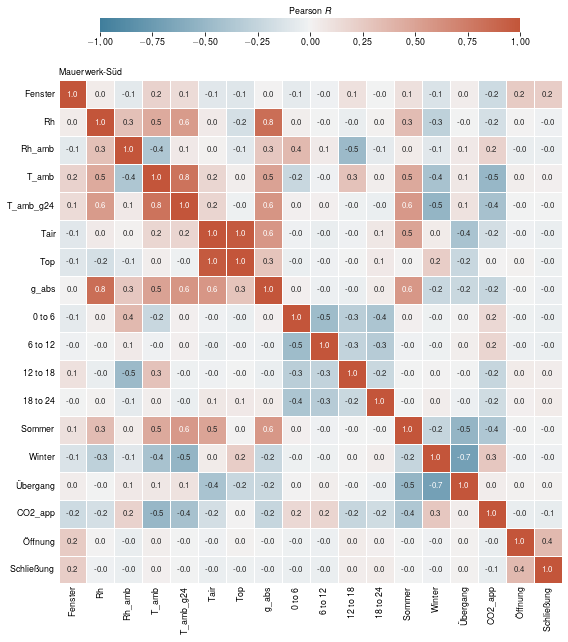

In [40]:
corr=[]
for (bui, app), group in data.groupby(['bui', 'app']):
    fig,ax = plt.subplots(figsize=(10,10))
    ax = tb.stats.CorreleationMatrix(group, ax=ax, annot_kws={"size":8})
    ax.set(title=f'{BUID[bui]}-{APPS[app]}', ylabel=None, xlabel=None)
    corr.append(group.groupby(level=0).median().corr()['Öffnung'].rename((bui, app)))
corr = pd.concat(corr, axis=1).drop(['Öffnung'])
corr.rank().sum(axis=1).sort_values(ascending=False).div(np.multiply(*corr.shape))

In [41]:
def exportLogModel(scaler, classifier, y=None, timestep=1, n=5, path='sim/robust-inputs', export=True, tex=False):
    params = pd.DataFrame([scaler.mean_, scaler.scale_, classifier.coef_[0], classifier.intercept_], index = ['mean', 'scale', 'coeff', 'intercept'], columns = scaler.feature_names_in_).rename(columns={'Übergang':'Uebergang'})
    scale = 1
    if y is not None:
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_ind = le.fit_transform(y)
        if not all(np.in1d(classifier.classes_, le.classes_)):
            raise ValueError("classes should have valid labels that are in y")

        recip_freq = len(y) / (len(le.classes_) * np.bincount(y_ind).astype(np.float64))
        weight = recip_freq[le.transform(classifier.classes_)]
        scale = (weight/weight[0])[1]

    proba = pd.DataFrame(np.random.default_rng().uniform(0,1*scale, (8760*int(1/timestep), n)), columns = [f'LogReg_PROBA_{i}' for i in range(n)])

    if export:
        params.to_csv(os.path.join(path, 'logreg_params.csv'))
        proba.to_csv(os.path.join(path, 'logreg_proba.csv'), index=False, index_label='HoY')
    if tex:
        exportParameterTable(params)
    print(params)
    return params, proba

def exportParameterTable(params, filename='LogReg_params'):
    (params
    .rename(index = {'coeff': r'$\beta_k$', 'intercept': r'$\beta_0$', 'mean': r'$\overline{x}_k$', 'scale':r'$\sigma_k$'},columns=TexMapper)
    .rename_axis(['Prädikatoren'], axis=1)
    .style
    .format(precision=1, escape='latex')
    .to_latex(
        f'./LaTex/tbls/tbl_emp_{filename}.tex',
        caption='Bestimmte Regressionskoeffizienten $\\beta_k$, $\\beta_0$ sowie die Skalierungsfaktoren $\\overline{x}_k$ und $\\sigma_k$ für die ausgewählten Prädiktoren',
        clines="skip-last;data",
        siunitx=True,
        hrules=True,
        position= 'H',
        position_float="centering",
        multicol_align="|c|",
        label='tbl:DatensatzRegression')
        )

def Regressionsanalyse(dataset=None, exog=None, CRIT=None, ci=95, ax=None, toTex=None, hist_kws=dict(), **axis_kws):
    if dataset is not None and exog is None and CRIT is None: 
        if dataset.shape[1] == 2:
            exog = dataset.columns[0]
            CRIT = dataset.columns[1]
            df = dataset
    elif exog is not None and CRIT is not None and dataset is None:
        df = pd.concat([exog, CRIT], axis=1)
        exog = exog.Name
        CRIT = exog.CRIT
    elif dataset is not None and isinstance(exog, str) and isinstance(CRIT, str):
        df = dataset[[exog, CRIT]]
    else:
        raise AttributeError('Inputs falsch definiert')
    
    data = df.where(lambda x: x[exog].between(*tb.stats.ci(x[exog], which=ci))).dropna()
    x = data[exog].values.reshape(-1, 1)
    y = data[CRIT]

    scaler = StandardScaler().fit(x)
    rg = LogisticRegressionCV(solver='liblinear', class_weight='balanced', fit_intercept=True).fit(scaler.transform(x), y)

    x_pred = np.linspace(df[exog].min(),df[exog].max(), 100).reshape(-1, 1)

    y_pred = rg.predict_proba(scaler.transform(x_pred))[:,1]
    if ax is None:
        fig, ax = plt.subplots(**style.size(.4, fraction=.4))
    ax = sns.histplot(data=df, x=exog, y=CRIT, **hist_kws)
    ax.plot(x_pred, y_pred, color=style.clrs[1], marker='v', markevery=10)
    ax.set(**axis_kws)
    test = f'$\\beta_0$: {rg.intercept_[0]:.2n}\n$\\beta_1$: {rg.coef_[0][0]:.2n}'
    ax.text(0.05,0.85,test, va='top', ha='left', transform=ax.transAxes, bbox=style.bbox_props)
    ax.grid(axis='both')
    fig.tight_layout()
    if isinstance(toTex, str):
        style.toTex('desc', f'LogReg_{exog}_{CRIT}_{toTex}')
    return ax

def addInteraction(df, columns_A, columns_B):
    for combo in itertools.product(columns_A, columns_B):
        df['x'.join(combo)] = df[combo[0]] * df[combo[1]]
    return df

In [42]:
CRIT = 'Fenster'
freq = '15min'
feature_names = ['Tair', 'Rh', 'g_abs', 'Rh_amb', 'CO2', 'T_amb', 'T_amb_g24']
dataset = pd.concat(
        [
        getData(value=feature_names, app=['N', 'S'], room=['SZ', 'WZ', 'K'], occupied=True).groupby(level=[0,1,3], axis=1).median().resample(freq).mean().stack([0,1]),
        getData(value=['Fenster'], app=['N', 'S'], room=['SZ', 'WZ', 'K'], occupied=True).where(lambda x: x>0).groupby(level=[0,1,3], axis=1).sum(min_count=1).resample(freq).sum().stack([0,1]),
        getData(value=['Fensteröffnung'], app=['N', 'S'], room=['SZ', 'WZ', 'K'], occupied=True).where(lambda x: x>0).groupby(level=[0,1,3], axis=1).sum(min_count=1).resample(freq).sum().stack([0,1]),
        getData(value=['Fensteröffnung'], app=['N', 'S'], room=['SZ', 'WZ', 'K'], occupied=True).where(lambda x: x<0).groupby(level=[0,1,3], axis=1).sum(min_count=1).resample(freq).sum().stack([0,1]).set_axis(['Fensterschließung'], axis=1).abs()
        ], axis=1).round(2).dropna().reset_index()
dataset = dataset.assign(deltaT = lambda x: x.T_amb - x.Tair)
steps = 6
DayRange = [f'{x1} to {x2}' for x1, x2 in zip(np.arange(0,24+steps,steps), np.arange(steps, 24+steps, steps))]
dataset = dataset.merge(pd.get_dummies(pd.cut(dataset.Datetime.dt.hour, bins=np.arange(0,24+steps,steps), labels = DayRange, right=False)), right_index=True, left_index=True)
dataset = dataset.merge(pd.get_dummies(tb.utils.getSeason(dataset.Datetime.dt.month)), right_index=True, left_index=True)
fixedEffects = [*DayRange,'Sommer', 'Winter', 'Übergang']
dataset['Fenster'] = (dataset['Fenster'] > 0).astype(int)
dataset['Fensterschließung'] = (dataset['Fensterschließung'] > 0).astype(int)
dataset['Fensteröffnung'] = (dataset['Fensteröffnung'] > 0).astype(int)
dataset = dataset.drop(['bui', 'app', 'Datetime'], axis=1).round(1)
#dataset = addInteraction(dataset, DayRange, ['Sommer', 'Winter', 'Übergang', 'CO2', 'deltaT'])
print(dataset.shape)

dataset.head()

(126971, 18)


,CO2,Rh,Rh_amb,T_amb,T_amb_g24,Tair,g_abs,Fenster,Fensteröffnung,Fensterschließung,deltaT,0 to 6,6 to 12,12 to 18,18 to 24,Sommer,Winter,Übergang
0,604.4,55.6,53.4,5.2,5.1,21.5,8.8,1,1,1,-16.3,0,1,0,0,0,0,1
1,639.0,47.5,53.4,5.2,5.1,22.4,7.8,0,0,0,-17.1,0,1,0,0,0,0,1
2,534.8,52.6,50.8,6.2,5.6,21.9,8.6,1,1,0,-15.7,0,1,0,0,0,0,1
3,671.1,48.0,50.8,6.2,5.6,22.7,8.0,0,0,0,-16.5,0,1,0,0,0,0,1
4,517.9,51.3,46.4,6.8,5.9,21.9,8.3,1,1,1,-15.1,0,1,0,0,0,0,1


## Regressionsanalysen mit nur einem Kriterium

<AxesSubplot:xlabel='$\\beta_1 \\Delta T [\\si{\\kelvin}]$', ylabel='$P_{Fenster}(\\Delta T)$'>

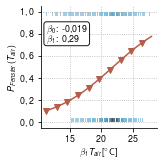

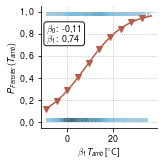

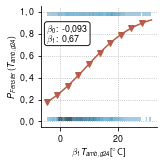

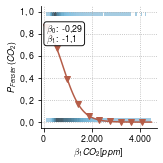

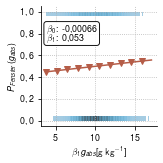

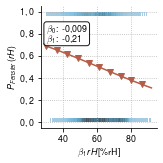

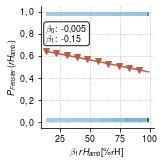

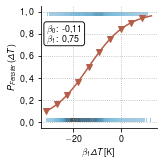

In [43]:
_CRIT = 'Fenster'
Regressionsanalyse(dataset, 'Tair', _CRIT, xlabel=r'$\beta_1 T_{air} [\si{\celsius}]$', ylabel=r'$P_{Fenster}(T_{air})$')
Regressionsanalyse(dataset, 'T_amb', _CRIT, xlabel=r'$\beta_1 T_{amb} [\si{\celsius}]$', ylabel=r'$P_{Fenster}(T_{amb})$')
Regressionsanalyse(dataset, 'T_amb_g24', _CRIT, xlabel=r'$\beta_1 T_{amb,g24} [\si{\celsius}]$', ylabel=r'$P_{Fenster}(T_{amb,g24})$')
Regressionsanalyse(dataset, 'CO2', _CRIT, xlabel=r'$\beta_1 CO_2 [ppm]$', ylabel=r'$P_{Fenster}(CO_2)$')
Regressionsanalyse(dataset, 'g_abs', _CRIT, xlabel=r'$\beta_1 g_{abs} [\si{\gram\per\kilo\gram}]$', ylabel=r'$P_{Fenster}(g_{abs})$')
Regressionsanalyse(dataset, 'Rh', _CRIT, xlabel=r'$\beta_1 rH [\si{\percent rH}]$', ylabel=r'$P_{Fenster}(rH)$')
Regressionsanalyse(dataset, 'Rh_amb', _CRIT, xlabel=r'$\beta_1 rH_{amb} [\si{\percent rH}]$', ylabel=r'$P_{Fenster}(rH_{amb})$')
Regressionsanalyse(dataset, 'deltaT', _CRIT, xlabel=r'$\beta_1 \Delta T [\si{\kelvin}]$', ylabel=r'$P_{Fenster}(\Delta T)$')

<AxesSubplot:xlabel='$\\beta_1 \\Delta T [\\si{\\kelvin}]$', ylabel='$P_{Fensteröffnung}(\\Delta T)$'>

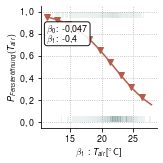

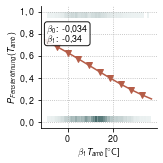

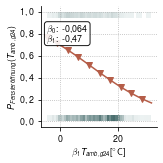

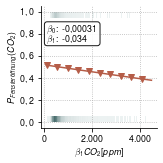

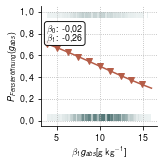

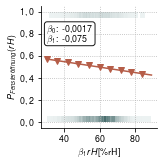

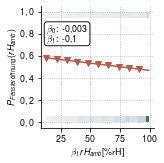

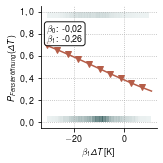

In [44]:
_CRIT = 'Fensterschließung'
hist_kws = dict(cmap=style.Greens)
df = dataset[dataset.Fenster == 1]
Regressionsanalyse(df, 'Tair', _CRIT, hist_kws=hist_kws, xlabel=r'$\beta_1: T_{air} [\si{\celsius}]$', ylabel=r'$P_{Fensteröffnung}(T_{air})$')
Regressionsanalyse(df, 'T_amb', _CRIT, hist_kws=hist_kws, xlabel=r'$\beta_1 T_{amb} [\si{\celsius}]$', ylabel=r'$P_{Fensteröffnung}(T_{amb})$')
Regressionsanalyse(df, 'T_amb_g24', _CRIT, hist_kws=hist_kws, xlabel=r'$\beta_1 T_{amb,g24} [\si{\celsius}]$', ylabel=r'$P_{Fensteröffnung}(T_{amb,g24})$')
Regressionsanalyse(df, 'CO2', _CRIT, hist_kws=hist_kws, xlabel=r'$\beta_1 CO_2 [ppm]$', ylabel=r'$P_{Fensteröffnung}(CO_2)$')
Regressionsanalyse(df, 'g_abs', _CRIT, hist_kws=hist_kws, xlabel=r'$\beta_1 g_{abs} [\si{\gram\per\kilo\gram}]$', ylabel=r'$P_{Fensteröffnung}(g_{abs})$')
Regressionsanalyse(df, 'Rh', _CRIT, hist_kws=hist_kws, xlabel=r'$\beta_1 rH [\si{\percent rH}]$', ylabel=r'$P_{Fensteröffnung}(rH)$')
Regressionsanalyse(df, 'Rh_amb', _CRIT, hist_kws=hist_kws, xlabel=r'$\beta_1 rH_{amb} [\si{\percent rH}]$', ylabel=r'$P_{Fensteröffnung}(rH_{amb})$')
Regressionsanalyse(df, 'deltaT', _CRIT, hist_kws=hist_kws, xlabel=r'$\beta_1 \Delta T [\si{\kelvin}]$', ylabel=r'$P_{Fensteröffnung}(\Delta T)$')